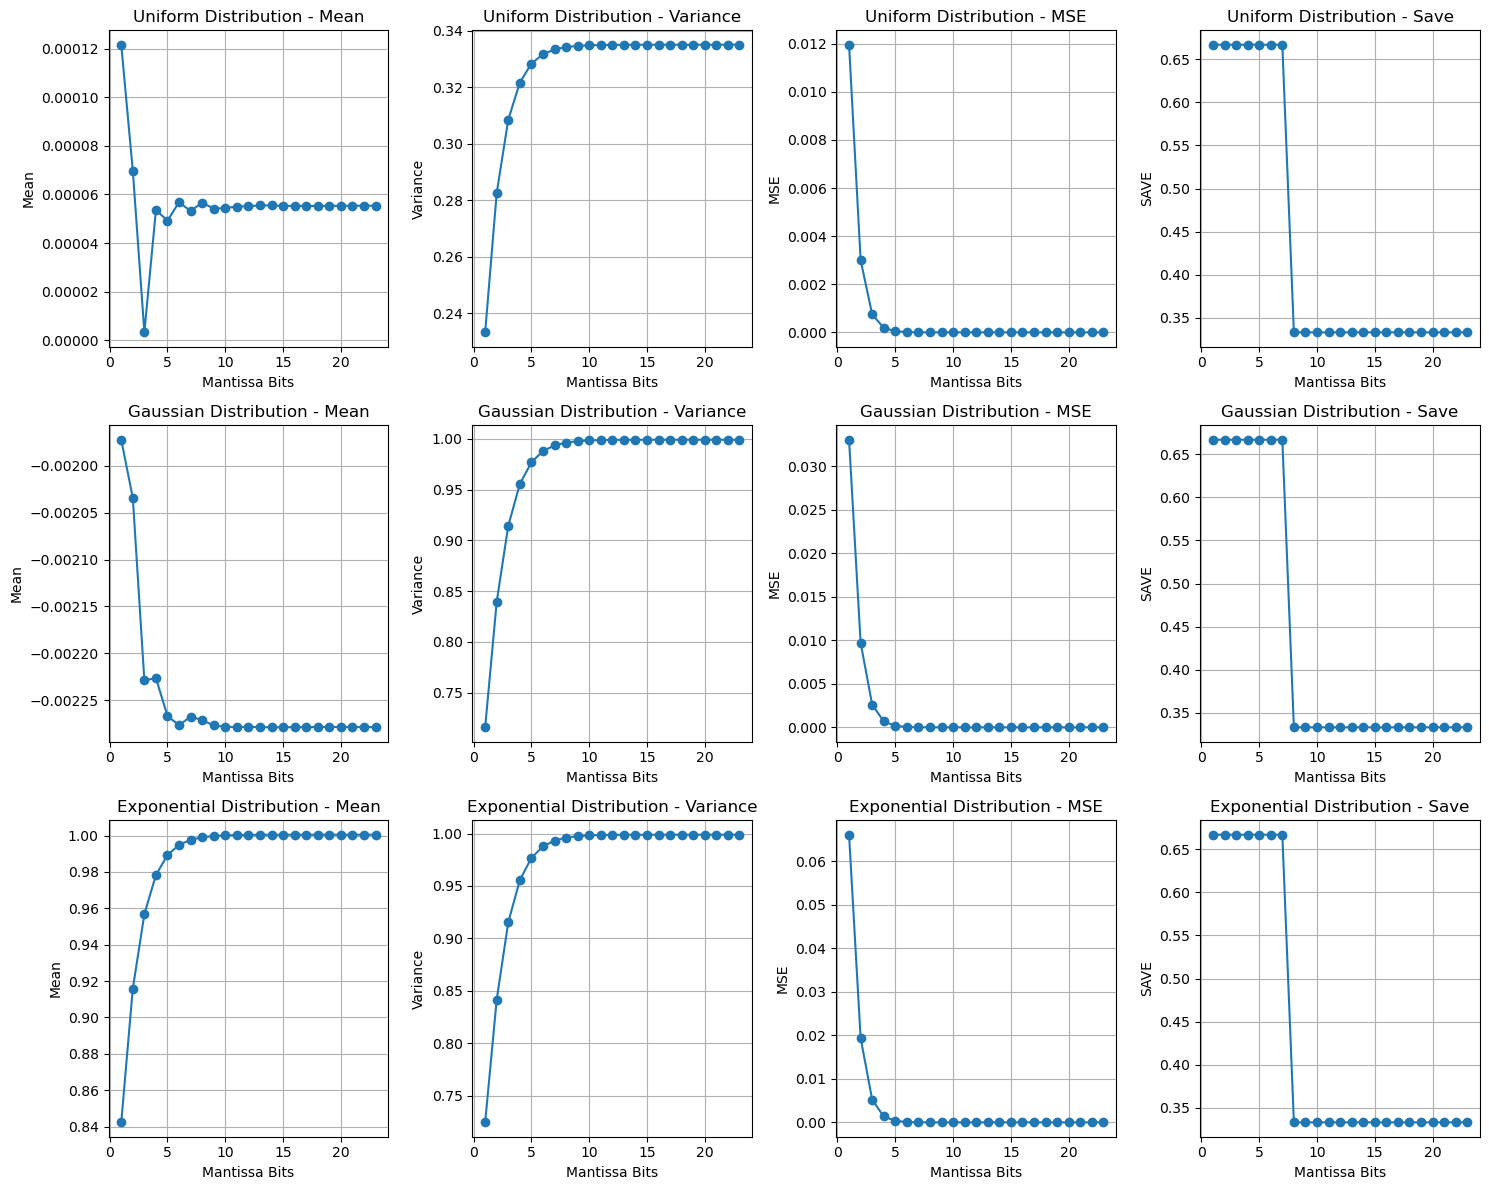

In [11]:
import numpy as np
import struct
import os
import matplotlib.pyplot as plt

# Generate large datasets
num_samples = 100000
uniform_data = np.random.uniform(-1, 1, num_samples).astype(np.float32)
gaussian_data = np.random.normal(0, 1, num_samples).astype(np.float32)
exponential_data = np.random.exponential(1, num_samples).astype(np.float32)
uniform_data.tofile("uniform_data.bin") 
gaussian_data.tofile("gaussian_data.bin")
exponential_data.tofile("exponential_data.bin")
uniform_size = os.path.getsize("uniform_data.bin")
gaussian_size = os.path.getsize("gaussian_data.bin")
exponential_size = os.path.getsize("exponential_data.bin")

def compress_floats(data, mantissa_bits):
    compressed_data = []
    for num in data:
        packed = struct.unpack('!I', struct.pack('!f', num))[0]  # Convert float to int bits
        sign = (packed >> 31) & 0x1  # Extract sign bit
        exponent = (packed >> 23) & 0xFF  # Extract exponent (8 bits)
        mantissa = packed & 0x7FFFFF  # Extract mantissa (23 bits)
        
        # Truncate mantissa
        truncated_mantissa = mantissa >> (23 - mantissa_bits)
        compressed_data.append((sign, exponent, truncated_mantissa))
    
    return compressed_data

def decompress_floats(compressed_data, mantissa_bits):
    decompressed_data = []
    for sign, exponent, truncated_mantissa in compressed_data:
        full_mantissa = truncated_mantissa << (23 - mantissa_bits)  # Pad missing bits with 0s
        packed = (sign << 31) | (exponent << 23) | full_mantissa  # Reconstruct IEEE float
        num = struct.unpack('!f', struct.pack('!I', packed))[0]  # Convert back to float
        decompressed_data.append(np.float16(num))  # Convert to float16
    
    return np.array(decompressed_data, dtype=np.float16)

def compute_mse(original, compressed):
    return np.mean((original - compressed) ** 2, dtype=np.float32)

# Iterate over mantissa bit sizes from 16 to 23
mantissa_range = range(1, 24)

stats_uniform = {'mean': [], 'variance': [], 'mse': []}
stats_gaussian = {'mean': [], 'variance': [], 'mse': []}
stats_exponential = {'mean': [], 'variance': [], 'mse': []}
storage_save_uniform = {'mantissa': [], '%save': []}
storage_save_gaussian = {'mantissa': [], '%save': []}
storage_save_exponential = {'mantissa': [], '%save': []}

for mantissa_bits in mantissa_range:
    compressed_uniform = compress_floats(uniform_data, mantissa_bits)
    compressed_gaussian = compress_floats(gaussian_data, mantissa_bits)
    compressed_exponential = compress_floats(exponential_data, mantissa_bits)
    
    decompressed_uniform = decompress_floats(compressed_uniform, mantissa_bits)
    decompressed_gaussian = decompress_floats(compressed_gaussian, mantissa_bits)
    decompressed_exponential = decompress_floats(compressed_exponential, mantissa_bits)
    if mantissa_bits > 7 : 
        np.array(compressed_uniform, dtype=np.float32).tofile(f"compressed_uniform_{mantissa_bits}.bin")
        np.array(compressed_gaussian, dtype=np.float32).tofile(f"compressed_gaussian_{mantissa_bits}.bin")
        np.array(compressed_exponential, dtype=np.float32).tofile(f"compressed_exponential_{mantissa_bits}.bin")
    else : 
        np.array(compressed_uniform, dtype=np.float16).tofile(f"compressed_uniform_{mantissa_bits}.bin")
        np.array(compressed_gaussian, dtype=np.float16).tofile(f"compressed_gaussian_{mantissa_bits}.bin")
        np.array(compressed_exponential, dtype=np.float16).tofile(f"compressed_exponential_{mantissa_bits}.bin")
    

        
    uniform = uniform_size / os.path.getsize(f"compressed_uniform_{mantissa_bits}.bin")
    gaussian = gaussian_size / os.path.getsize(f"compressed_gaussian_{mantissa_bits}.bin")
    exponential = exponential_size / os.path.getsize(f"compressed_exponential_{mantissa_bits}.bin")
    
    storage_save_uniform['mantissa'].append(mantissa_bits)
    storage_save_uniform['%save'].append(uniform)
    storage_save_gaussian['mantissa'].append(mantissa_bits)
    storage_save_gaussian['%save'].append(gaussian)
    storage_save_exponential['mantissa'].append(mantissa_bits)
    storage_save_exponential['%save'].append(exponential)
    
    stats_uniform['mean'].append(np.mean(decompressed_uniform, dtype=np.float32))
    stats_uniform['variance'].append(np.var(decompressed_uniform, dtype=np.float32))
    stats_uniform['mse'].append(compute_mse(uniform_data, decompressed_uniform))
    
    stats_gaussian['mean'].append(np.mean(decompressed_gaussian, dtype=np.float32))
    stats_gaussian['variance'].append(np.var(decompressed_gaussian, dtype=np.float32))
    stats_gaussian['mse'].append(compute_mse(gaussian_data, decompressed_gaussian))
    
    stats_exponential['mean'].append(np.mean(decompressed_exponential, dtype=np.float32))
    stats_exponential['variance'].append(np.var(decompressed_exponential, dtype=np.float32))
    stats_exponential['mse'].append(compute_mse(exponential_data, decompressed_exponential))

# Plot results
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

def plot_stat(ax, x, y, title, ylabel):
    ax.plot(x, y, marker='o')
    ax.set_title(title)
    ax.set_xlabel("Mantissa Bits")
    ax.set_ylabel(ylabel)
    ax.grid()

plot_stat(axs[0, 0], mantissa_range, stats_uniform['mean'], "Uniform Distribution - Mean", "Mean")
plot_stat(axs[0, 1], mantissa_range, stats_uniform['variance'], "Uniform Distribution - Variance", "Variance")
plot_stat(axs[0, 2], mantissa_range, stats_uniform['mse'], "Uniform Distribution - MSE", "MSE")
plot_stat(axs[0, 3], mantissa_range, storage_save_uniform['%save'], "Uniform Distribution - Save", "SAVE")

plot_stat(axs[1, 0], mantissa_range, stats_gaussian['mean'], "Gaussian Distribution - Mean", "Mean")
plot_stat(axs[1, 1], mantissa_range, stats_gaussian['variance'], "Gaussian Distribution - Variance", "Variance")
plot_stat(axs[1, 2], mantissa_range, stats_gaussian['mse'], "Gaussian Distribution - MSE", "MSE")
plot_stat(axs[1, 3], mantissa_range, storage_save_gaussian['%save'], "Gaussian Distribution - Save", "SAVE")

plot_stat(axs[2, 0], mantissa_range, stats_exponential['mean'], "Exponential Distribution - Mean", "Mean")
plot_stat(axs[2, 1], mantissa_range, stats_exponential['variance'], "Exponential Distribution - Variance", "Variance")
plot_stat(axs[2, 2], mantissa_range, stats_exponential['mse'], "Exponential Distribution - MSE", "MSE")
plot_stat(axs[2, 3], mantissa_range, storage_save_exponential['%save'], "Exponential Distribution - Save", "SAVE")

plt.tight_layout()
plt.show()

Floating-point numbers are represented and processed using the IEEE 754 floating-point standard, where different formats allocate varying numbers of bits for the sign, exponent, and mantissa. In this case, we compare `float16` (1-bit sign, 5-bit exponent, 10-bit mantissa) and `float32` (1-bit sign, 8-bit exponent, 23-bit mantissa) to analyze how statistical accuracy and storage efficiency change as the precision of the mantissa varies from 1 bit to 23 bits.  

The graphs reveal a noticeable trend: storage savings occur when using fewer than 8 bits for the mantissa. This is expected, as data with a mantissa precision of less than 8 bits is stored using the `float16` format, while data requiring more than 8 bits of mantissa precision is stored using `float32`.  

Additionally, we observe that key statistical measures, such as the mean and variance, begin to diverge significantly from their original values when the mantissa precision approaches 8 bits. The mean squared error (MSE) also increases sharply at this threshold. This suggests that when storing floating-point numbers with a mantissa of approximately—but not exceeding—8 bits, we achieve an optimal trade-off between statistical accuracy and storage efficiency.